In [1]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import sys,os
from lmu_networks import LMUProcess, LMUModulatedProcess, LMUNetwork, LMUModulatedNetwork

## LMUs
An LMU memory state, $\mathbf{m} \in \mathbb{R}^{q}$, for an order $q$ Legendre representation, is updated according to 
\begin{equation}
    \dot{\mathbf{m}}(t) =  A\mathbf{m}(t) +  Bu(t),
\end{equation}

where $u(t)$ is the input signal and $A$ and $B$ are given by 
\begin{equation}
    A_{ij} =\frac{(2i + 1)}{\theta} \begin{cases}
        -1 & i < j \\
        (-1)^{i-j+1} & i \geq j
    \end{cases}, \quad B_{i} = \frac{(2i + 1)(-1)^{i}}{\theta}.
    \end{equation}
    
 $\theta$ is the time window of the memory.
    
   An approximation of the input in the past, at, say $k\theta$ seconds in the past ($0\leq k \leq 1$) is given by 
   
   $$u(t-k) \approx \mathbf{P}^q(k)\mathbf{m}(t)$$
   
   where $\mathbf{P}^{q_a}(k) \in \mathbb{R}^{1 \times q}$ is the vector of the shifted Legendre polynomials (of degree one to $q$), evaluated at $k$.
   
   When implementing the LMU dynamics using the NEF, we can have a neural population representing $\mathbf{m}(t)$ which takes input $u(t)$ with incoming weights set to approximate the transform $\tau B$ (where $\tau$ is the synaptic constant on the connections) and recurrent connections set to approximate the transform $I +\tau A$. When the memory needs to be reset (e.g., when an episode ends), the population representing $\mathbf{m}(t)$ can be inhibited.
   
   If we want to remember a vector signal $\mathbf{u}(t) \in \mathbb{R}^n$ instead of a scalar signal, we can use multiple LDNs, all stacked together in a matrix, $\mathbf{m} \in \mathbb{R}^{q \times n}$:
  \begin{equation}
    \dot{\mathbf{m}}(t) =  A\mathbf{m}(t) +  \begin{bmatrix} B , \dots , B \end{bmatrix} \mathbf{u}(t),
\end{equation} 
   To obtain past values:  
    $$\mathbf{u}(t-\tau) \approx (\mathbf{P}^q(\tau)\mathbf{m}(t))^T$$

## Memory with the LMU
In this example, we create a nengo network that includes a LMU and use a Legendre matrix to compute a delay from the LMU memory. Here we use LMUProcess rather than the LMUNetwork -- so the LMU dynamics are computed exactly rather than approximated with a recurrent spiking neural population

In [2]:
theta = 0.2
q=10
delay = 1 # in units of theta; 1 means get signal delayed by theta (0.2s in the past), 0.5 means delayed by 0.5*theta (0.1s in the past), etc.

model = nengo.Network()
with model:
    # Some random input signal
    inp = nengo.Node(nengo.processes.WhiteSignal(1.0, high=5, rms=0.3, seed=0))

    # Defining the LMU
    #theta is the memory window size, q is the dimensionality of the LMU hidden/memory state, size_in is the dimensionality of the input
    lmu = LMUProcess(theta=theta, q=q, size_in=1) 
    memory = nengo.Node(lmu) # Storing the LMU in a nengo node so it is 'run' by nengo.Simulator
    nengo.Connection(inp, memory, synapse=None) # Feeding the random signal as input

    # Computing the delay
    recall = nengo.Node(size_in=1) # a node where the delay will go
    delay_matrix = np.kron(np.eye(1),lmu.get_weights_for_delays(delay)) # the Legendre delay matrix 
    nengo.Connection(memory, recall, transform = delay_matrix)
    
    in_p = nengo.Probe(inp, synapse=None)
    mem_p = nengo.Probe(memory, synapse=None)
    recall_p = nengo.Probe(recall, synapse=None)
    
with nengo.Simulator(model) as sim:
    sim.run(1.5)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

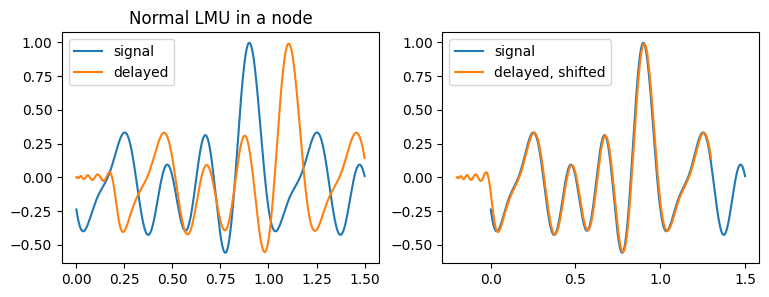

In [3]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.title("Normal LMU in a node")
plt.plot(ts, sim.data[in_p])
plt.plot(ts, sim.data[recall_p])
plt.legend(['signal','delayed'])

plt.subplot(1,2,2)
plt.plot(ts, sim.data[in_p])
plt.plot(ts - theta, sim.data[recall_p])
plt.legend(['signal','delayed, shifted'])

We can reset the LMU memory:

In [4]:
theta = 0.2
q=10
delay = 1 # in units of theta; 1 means get signal delayed by theta (0.2s in the past), 0.5 means delayed by 0.5*theta (0.1s in the past), etc.

model = nengo.Network()
with model:
    # Some random input signal
    inp = nengo.Node(nengo.processes.WhiteSignal(1.0, high=5, rms=0.3, seed=0))

    # reset signal
    reset = nengo.Node(lambda t: (t % 0.4) < 0.01 if t>0.01 else 0)

    # Defining the LMU
    #theta is the memory window size, q is the dimensionality of the LMU hidden/memory state, size_in is the dimensionality of the input
    lmu = LMUProcess(theta=theta, q=q, size_in=1, with_resets=True) 
    memory = nengo.Node(lmu) # Storing the LMU in a nengo node so it is 'run' by nengo.Simulator
    nengo.Connection(inp, memory[1:], synapse=None) # Feeding the random signal as input
    nengo.Connection(reset, memory[0], synapse=None)

    # Computing the delay
    recall = nengo.Node(size_in=1) # a node where the delay will go
    delay_matrix = np.kron(np.eye(1),lmu.get_weights_for_delays(delay)) # the Legendre delay matrix 
    nengo.Connection(memory, recall, transform = delay_matrix)
    
    in_p = nengo.Probe(inp, synapse=None)
    mem_p = nengo.Probe(memory, synapse=None)
    recall_p = nengo.Probe(recall, synapse=None)
    reset_p = nengo.Probe(reset, synapse=None)
    
with nengo.Simulator(model) as sim:
    sim.run(1.5)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

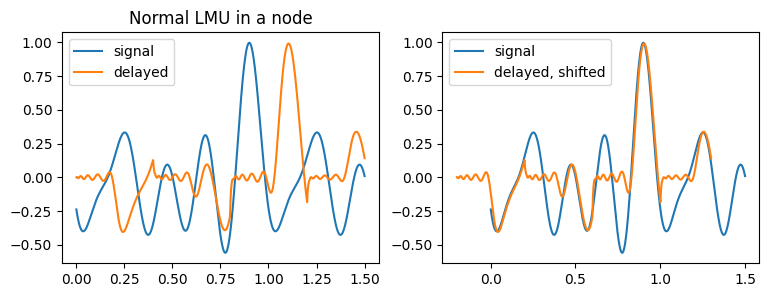

In [5]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.title("Normal LMU in a node")
plt.plot(ts, sim.data[in_p])
plt.plot(ts, sim.data[recall_p])
plt.legend(['signal','delayed'])

plt.subplot(1,2,2)
plt.plot(ts, sim.data[in_p])
plt.plot(ts - theta, sim.data[recall_p])
plt.legend(['signal','delayed, shifted'])

We can also 'hold' the LMU memory:

In [6]:
theta = 0.2
q=10
delay = 1 # in units of theta; 1 means get signal delayed by theta (0.2s in the past), 0.5 means delayed by 0.5*theta (0.1s in the past), etc.

model = nengo.Network()
with model:
    # Some random input signal
    inp = nengo.Node(nengo.processes.WhiteSignal(1.0, high=5, rms=0.3, seed=0))

    # hold signal
    hold = nengo.Node(lambda t: (t % 0.4) < 0.1 if t>0.1 else 0)

    # Defining the LMU
    #theta is the memory window size, q is the dimensionality of the LMU hidden/memory state, size_in is the dimensionality of the input
    lmu = LMUProcess(theta=theta, q=q, size_in=1, with_holds=True) 
    memory = nengo.Node(lmu) # Storing the LMU in a nengo node so it is 'run' by nengo.Simulator
    nengo.Connection(inp, memory[1:], synapse=None) # Feeding the random signal as input
    nengo.Connection(hold, memory[0], synapse=None)

    # Computing the delay
    recall = nengo.Node(size_in=1) # a node where the delay will go
    delay_matrix = np.kron(np.eye(1),lmu.get_weights_for_delays(delay)) # the Legendre delay matrix 
    nengo.Connection(memory, recall, transform = delay_matrix)
    
    in_p = nengo.Probe(inp, synapse=None)
    mem_p = nengo.Probe(memory, synapse=None)
    recall_p = nengo.Probe(recall, synapse=None)
    reset_p = nengo.Probe(hold, synapse=None)
    
with nengo.Simulator(model) as sim:
    sim.run(1.5)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

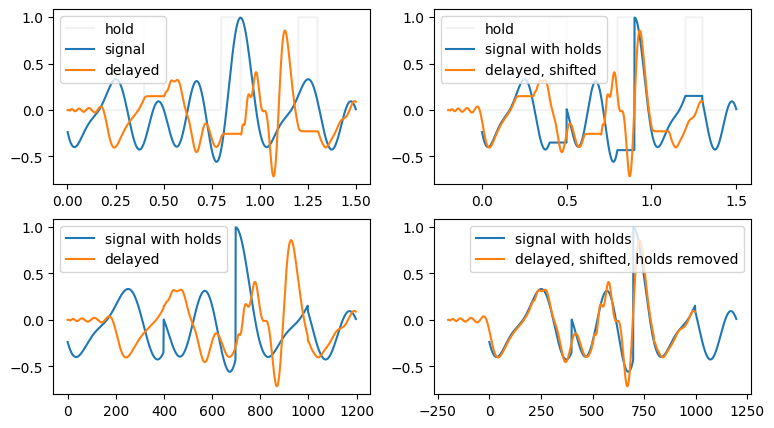

In [7]:
plt.figure(figsize=(9,5))


id_nohold = np.where(sim.data[reset_p][:,0]<0.5)
n_ts = len(id_nohold[0])

id_switch_on = np.where(sim.data[reset_p][:-1,0] - sim.data[reset_p][1:,0] < 0)[0]
id_switch_off = np.where(sim.data[reset_p][:-1,0] - sim.data[reset_p][1:,0] > 0)[0]

sig_hold =  sim.data[in_p].copy()
for i in range(len(id_switch_on)):
    sig_hold[id_switch_on[i]:id_switch_off[i]] = sig_hold[id_switch_on[i]]

plt.subplot(2,2,1)
plt.plot(ts, sim.data[reset_p],c='grey',alpha=0.1)
plt.plot(ts, sim.data[in_p])
plt.plot(ts, sim.data[recall_p])
plt.legend(['hold', 'signal','delayed'])


plt.subplot(2,2,2)
plt.plot(ts, sim.data[reset_p],c='grey',alpha=0.1)
plt.plot(ts, sig_hold)
plt.plot(ts - theta, sim.data[recall_p])
plt.legend(['hold', 'signal with holds','delayed, shifted'])


plt.subplot(2,2,3)
plt.plot(np.arange(n_ts), sim.data[in_p][id_nohold])
plt.plot(np.arange(n_ts), sim.data[recall_p][id_nohold])
plt.legend(['signal with holds','delayed'])


plt.subplot(2,2,4)
plt.plot(np.arange(n_ts), sim.data[in_p][id_nohold])
plt.plot(np.arange(n_ts) - int(theta/sim.dt), sim.data[recall_p][id_nohold])
plt.legend(['signal with holds','delayed, shifted, holds removed'])

Here we use 'LMUModulatedProcess': this is an LMU with an expanding memory window. As we compute the delayed signal from the LMU state, we will be getting output from further in the past over time

In [8]:
theta = 0.1
theta_rate = 1.001 # rate of window expansion
# to do: find notes for computing this right given a desired change in theta from theta_0 to theta_1 in time interval dt
#        and then replace this
q=10
model = nengo.Network()
with model:
    inp = nengo.Node(nengo.processes.WhiteSignal(1.0, high=5, rms=0.3, seed=0))
    ldn = LMUModulatedProcess(theta=theta, q=q, size_in=1)
    
    memory = nengo.Node(ldn)
    nengo.Connection(inp, memory[1:], synapse=None)
    modulator = nengo.Node(theta_rate) 
    nengo.Connection(modulator, memory[0], synapse=None)
    
    recall = nengo.Node(size_in=1)
    delay_matrix = np.kron(np.eye(1),ldn.get_weights_for_delays(1))
    nengo.Connection(memory, recall, transform = delay_matrix)
    
    in_p = nengo.Probe(inp, synapse=None)
    mem_p = nengo.Probe(memory, synapse=None)
    recall_p = nengo.Probe(recall, synapse=None)
    
with nengo.Simulator(model) as sim:
    sim.run(1.5)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

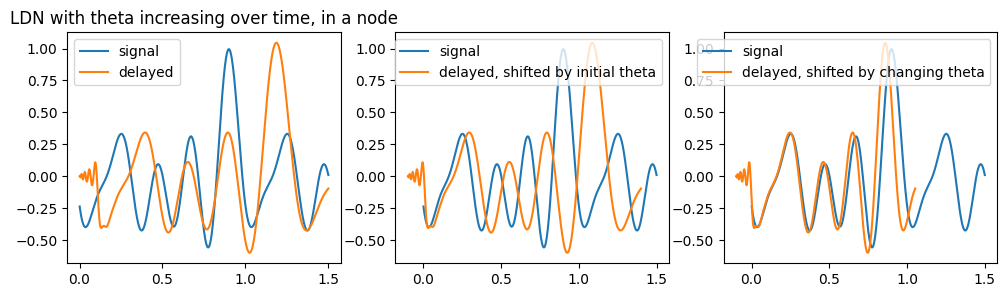

In [9]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title("LDN with theta increasing over time, in a node")
plt.plot(ts, sim.data[in_p])
plt.plot(ts, sim.data[recall_p])
plt.legend(['signal','delayed'])

plt.subplot(1,3,2)
plt.plot(ts, sim.data[in_p])
plt.plot(ts - theta, sim.data[recall_p])
plt.legend(['signal','delayed, shifted by initial theta'])


plt.subplot(1,3,3)
plt.plot(ts, sim.data[in_p])
plt.plot(ts - theta*theta_rate**np.arange(len(ts)), sim.data[recall_p])
plt.legend(['signal','delayed, shifted by changing theta'])

## LMU as a recurrent neural network
Here we use LMUNetwork, a recurrent spiking neural network that models the LMU dynamics

In [10]:
theta = 0.2
q=10
n_neurons=300
tau=0.03
prb_syn=0.01
model = nengo.Network()
with model:
    inp = nengo.Node(nengo.processes.WhiteSignal(2, high=5, rms=0.3, seed=1))
    ldn = LMUNetwork(n_neurons, theta=theta, q=q, size_in=1, tau=tau)
    nengo.Connection(inp, ldn.input, synapse=None)
    
    
    in_p = nengo.Probe(inp, synapse=None)
    lmu_p = nengo.Probe(ldn.output, synapse=prb_syn)
    recall_p = nengo.Probe(ldn.delayed_output, synapse=prb_syn)
    
with nengo.Simulator(model,dt=0.001) as sim:
    sim.run(1.5)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

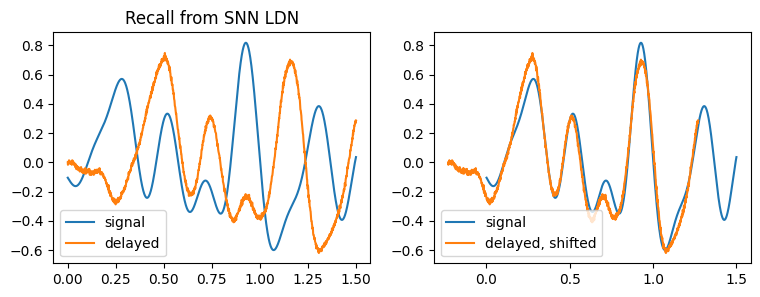

In [11]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)

plt.title("Recall from SNN LDN")
plt.plot(ts, sim.data[in_p])
plt.plot(ts, sim.data[recall_p])
plt.legend(['signal','delayed'])

plt.subplot(1,2,2)
plt.plot(ts, sim.data[in_p])
plt.plot(ts - theta -tau, sim.data[recall_p])
plt.legend(['signal','delayed, shifted'])

With changing $\theta$

In [12]:
theta = 0.1
theta_rate=1.001 
# to do: find notes for computing this right given a desired change in theta from theta_0 to theta_1 in time interval dt
#        and then replace this

q=10
n_neurons=300
tau=0.03
prb_syn=0.01
model = nengo.Network()
with model:
    inp = nengo.Node(nengo.processes.WhiteSignal(2, high=5, rms=0.3, seed=1))
    ldn = LMUModulatedNetwork(n_neurons, theta=theta, q=q, size_in=1, tau=tau)
    nengo.Connection(inp, ldn.input, synapse=None)
    
    modulator = nengo.Node(theta_rate)
    nengo.Connection(modulator, ldn.modulator, synapse=None)
    
    in_p = nengo.Probe(inp, synapse=None)
    lmu_p = nengo.Probe(ldn.output, synapse=prb_syn)
    recall_p = nengo.Probe(ldn.delayed_output, synapse=prb_syn)
    
with nengo.Simulator(model,dt=0.001) as sim:
    sim.run(1.5)
ts = sim.trange() 

/Users/nicoledumont/Documents/github/telluride-llm-ssm-bifurcation/lmu_networks.py:268: RuntimeWarning: divide by zero encountered in divide
  self.modulator = nengo.Node(lambda t,x: 1/x, size_in=1)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

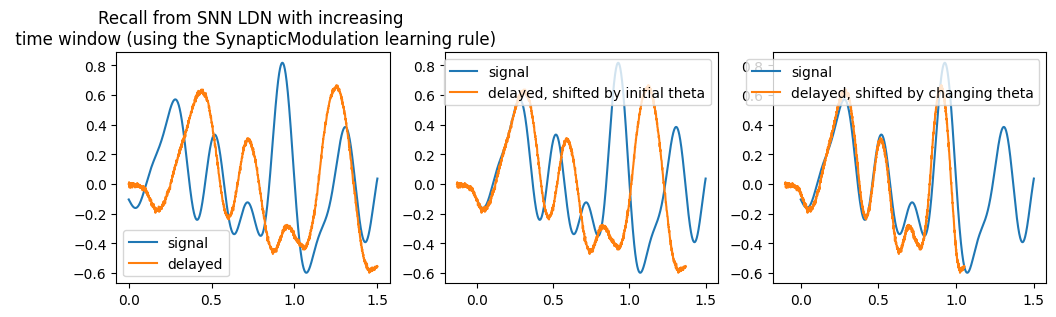

In [13]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title("Recall from SNN LDN with increasing \n time window (using the SynapticModulation learning rule)")
plt.plot(ts, sim.data[in_p])
plt.plot(ts, sim.data[recall_p])
plt.legend(['signal','delayed'])

plt.subplot(1,3,2)
plt.plot(ts, sim.data[in_p])
plt.plot(ts - theta -tau, sim.data[recall_p])
plt.legend(['signal','delayed, shifted by initial theta'])


plt.subplot(1,3,3)
plt.plot(ts, sim.data[in_p])
plt.plot(ts - theta*theta_rate**np.arange(len(ts)) , sim.data[recall_p])
plt.legend(['signal','delayed, shifted by changing theta'])